In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.special import rel_entr
import networkx as nx
from sklearn.metrics import r2_score

import os
import json

from biological_fuzzy_logic_networks.manuscripts_functions.colors import perturbation_models_dict
from biological_fuzzy_logic_networks.manuscripts_functions.metrics import compute_scalar_mmd, wasserstein_distance

In [2]:
fontsize = 12

In [3]:
sns.set_theme(font="Arial", style="ticks", rc={"font.size": fontsize,"axes.titlesize":fontsize,"axes.labelsize":fontsize, 
                                               "xtick.labelsize": fontsize, "ytick.labelsize": fontsize, "legend.fontsize": fontsize})
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = fontsize


In [4]:
folder = "/dccstor/ipc1/CAR/BFN/Model/init_dists/Output/test"
config_folder = "/dccstor/ipc1/CAR/BFN/Model/init_dists/Configs/"

In [5]:
n_repeats = 5
dists = ["normal", "bimodal", "uniform"]

data = []

for j in range(n_repeats):
    for dist in dists:
        exp_data = pd.read_csv(f"{folder}{dist}_repeat_{j}_predictions.csv", index_col=1)
        exp_data = exp_data.rename(columns={"Unnamed: 0":"model"})
        exp_data["dist"] = dist
        exp_data["repeat"] = j
        data.append(exp_data)
        
        

In [6]:
data = pd.concat(data)

In [7]:
data

,model,mek12,erk12,mkk4,jnk12,ikk,ikb,ras,map3k7,pi3k,map3k1,akt,p38,hsp27,dist,repeat
0,teacher_true,0.803626,0.857672,0.013989,0.006785,0.316707,0.368629,0.677860,0.450574,0.975257,0.078260,0.999913,0.002342,0.001039,normal,0
1,teacher_true,0.998972,1.000000,0.750599,0.825061,0.866524,0.977525,0.963737,0.744809,0.999939,0.696521,1.000000,0.609704,0.677795,normal,0
2,teacher_true,0.042201,0.009272,0.075768,0.033294,0.357994,0.424838,0.060508,0.393928,0.940300,0.305893,0.998783,0.011201,0.001158,normal,0
3,teacher_true,0.854907,0.932049,0.036026,0.012560,0.251183,0.282335,0.719855,0.248945,0.984211,0.285743,0.999977,0.002764,0.001116,normal,0
4,teacher_true,0.005406,0.001117,0.996857,0.999992,0.988627,0.999925,0.008208,0.949792,0.507474,0.925641,0.567490,0.992433,0.992322,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,untrained_random_input,0.416734,0.245131,0.999986,1.000000,1.000000,1.000000,0.551343,0.999964,0.999154,0.999004,0.999993,1.000000,1.000000,uniform,4
996,untrained_random_input,0.134551,0.054212,0.768968,0.855774,0.984781,0.998886,0.278866,0.837683,0.952564,0.790095,0.985730,0.687067,0.562986,uniform,4
997,untrained_random_input,0.120954,0.047934,0.244014,0.300171,0.997181,0.999962,0.258681,0.952964,0.999849,0.354414,1.000000,0.153023,0.066037,uniform,4
998,untrained_random_input,0.072635,0.027176,0.207060,0.164016,0.661946,0.609007,0.175920,0.536778,0.795835,0.522705,0.808735,0.062451,0.014348,uniform,4


In [8]:
output_markers = [c for c in data.columns if c not in ["model", "dist", "repeat"]]
markers = [
        "mek12",
        "erk12",
        "mkk4",
        "jnk12",
        "ikk",
        "ikb",
        "ras",
        "map3k7",
        "igf1",
        "pi3k",
        "il1a",
        "map3k1",
        "tgfa",
        "tnfa",
        "akt",
        "p38",
        "hsp27",
    ]

In [9]:
def compute_MSE(data, true_model_name: str):
    true = data[data["model"]==true_model_name]
    true = true.drop(["model", "dist", "repeat"], axis=1)
    true["repeat"] = 0 # So that repeat doesn't get lost when x-true. This doesn't cancel out the different repeats
    data = data.groupby("model").apply(lambda x: ((x-true)**2).groupby("repeat").mean())
    data = data.drop(["model", "dist"], axis=1)
    data = data.reset_index("model", drop=False)
    
    return data

def compute_R2(data, true_model_name: str, markers=output_markers):
    true = data[data["model"]==true_model_name]
    data = data.groupby("model").apply(lambda x: pd.Series([r2_score(true[m], x[m]) for m in markers]))
    data.columns=markers
    data[data==np.inf] = 0
    data = data.reset_index(drop=False)
    
    return data


def compute_MMD(data, true_model_name: str, markers=output_markers):
    true = data.loc[data["model"]==true_model_name, markers]
    data = data.groupby("model").apply(lambda x: compute_scalar_mmd(true, x[markers]))
    data = data.reset_index(drop=False)
    
    return data

def compute_wasserstein(data, true_model_name: str, markers=output_markers):
    true = data.loc[data["model"]==true_model_name, markers]
    data = data.groupby("model").apply(lambda x: wasserstein_distance(true, x[markers]))
    data = data.reset_index(drop=False)
    
    return data

In [10]:
data["model"].unique()

array(['teacher_true', 'student_same_input', 'student_random_input',
       'untrained_same_input', 'untrained_random_input'], dtype=object)

In [11]:
data_MSE = data.groupby(["dist"]).apply(compute_MSE, true_model_name="teacher_true").reset_index()
data_R2 = data.groupby(["dist", "repeat"]).apply(compute_R2, true_model_name="teacher_true").reset_index().drop("level_2", axis=1)

data_MMD = data.groupby(["dist", "repeat"]).apply(compute_MMD, true_model_name="teacher_true").reset_index().drop("level_2", axis=1).rename(columns={0: "MMD"})
data_EMD = data.groupby(["dist", "repeat"]).apply(compute_wasserstein, true_model_name="teacher_true").reset_index().drop("level_2", axis=1).rename(columns={0: "EMD"})
data_EMD["EMD"] = data_EMD["EMD"].astype(float)


2024-07-12 03:38:14.053697: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [12]:
avg_data_MSE = data_MSE.groupby(["dist", "model", "repeat"]).mean().reset_index()
avg_data_R2 = data_R2.groupby(["dist", "model", "repeat"]).mean().reset_index()
avg_data_MSE = avg_data_MSE.melt(id_vars=["dist", "model", "repeat"], value_name="Network MSE", var_name="node")
avg_data_R2 = avg_data_R2.melt(id_vars=["dist", "model", "repeat"], value_name="Network R2", var_name="node")
avg_data_MSE = avg_data_MSE.groupby(["dist", "model", "repeat"]).mean().reset_index()
avg_data_R2 = avg_data_R2.groupby(["dist", "model", "repeat"]).mean().reset_index()

avg_data_MSE

,dist,model,repeat,Network MSE
0,bimodal,student_random_input,0,0.269133
1,bimodal,student_random_input,1,0.252475
2,bimodal,student_random_input,4,0.250192
3,bimodal,student_random_input,9,0.226658
4,bimodal,student_random_input,16,0.259795
...,...,...,...,...
70,uniform,untrained_same_input,0,0.012024
71,uniform,untrained_same_input,1,0.005976
72,uniform,untrained_same_input,4,0.005626
73,uniform,untrained_same_input,9,0.007272


# MSE, same inputs

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


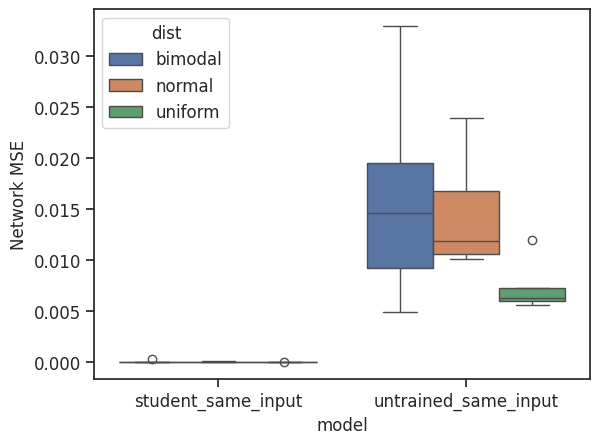

In [13]:
plt_data = avg_data_MSE[avg_data_MSE["model"].isin(['student_same_input', 'untrained_same_input'])]
sns.boxplot(data=plt_data, x="model", y="Network MSE", hue="dist")
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Init_distributions_MSE_boxplot_same_inputs_three_dists.pdf", bbox_inches="tight")

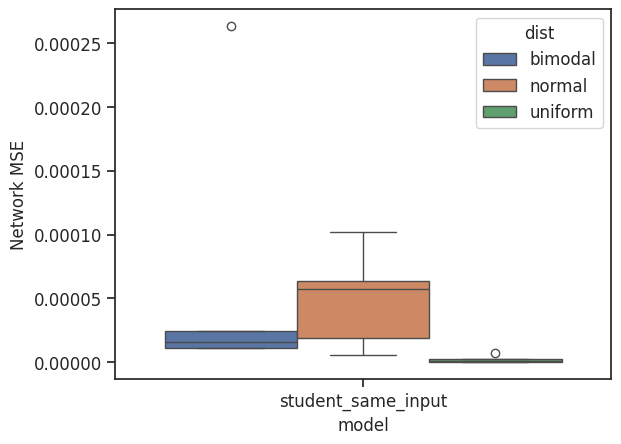

In [14]:
plt_data = avg_data_MSE[avg_data_MSE["model"]=='student_same_input']
sns.boxplot(data=plt_data, x="model", y="Network MSE", hue="dist")
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Init_distributions_MSE_boxplot_student_same_inputs_three_dists.pdf", bbox_inches="tight")

# R2, same inputs

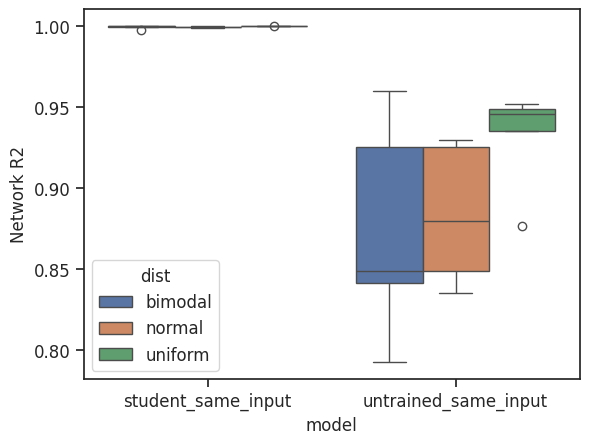

In [15]:
plt_data = avg_data_R2[avg_data_R2["model"].isin(['student_same_input', 'untrained_same_input'])]
sns.boxplot(data=plt_data, x="model", y="Network R2", hue="dist")
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Init_distributions_R2_boxplot_same_inputs_three_dists.pdf", bbox_inches="tight")

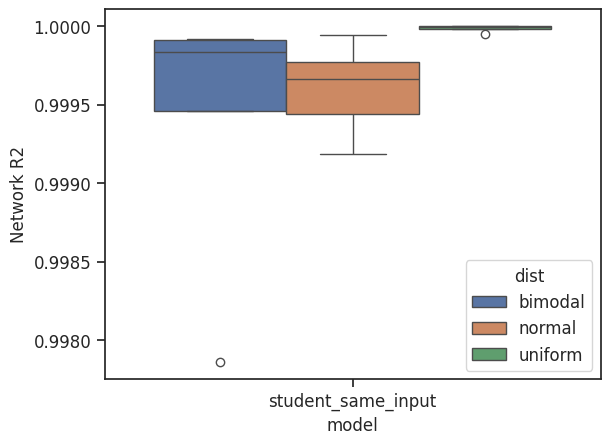

In [16]:
plt_data = avg_data_R2[avg_data_R2["model"]=='student_same_input']
sns.boxplot(data=plt_data, x="model", y="Network R2", hue="dist")
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Init_distributions_R2_boxplot_student_same_inputs_three_dists.pdf", bbox_inches="tight")

# MMD, all random and same inputs

In [17]:
data_MMD

,dist,repeat,model,MMD
0,bimodal,0,student_random_input,7.644470e-04
1,bimodal,0,student_same_input,3.556410e-06
2,bimodal,0,teacher_true,0.000000e+00
3,bimodal,0,untrained_random_input,5.699093e-03
4,bimodal,0,untrained_same_input,4.041401e-03
...,...,...,...,...
70,uniform,4,student_random_input,1.556632e-03
71,uniform,4,student_same_input,1.763304e-07
72,uniform,4,teacher_true,0.000000e+00
73,uniform,4,untrained_random_input,5.630674e-03


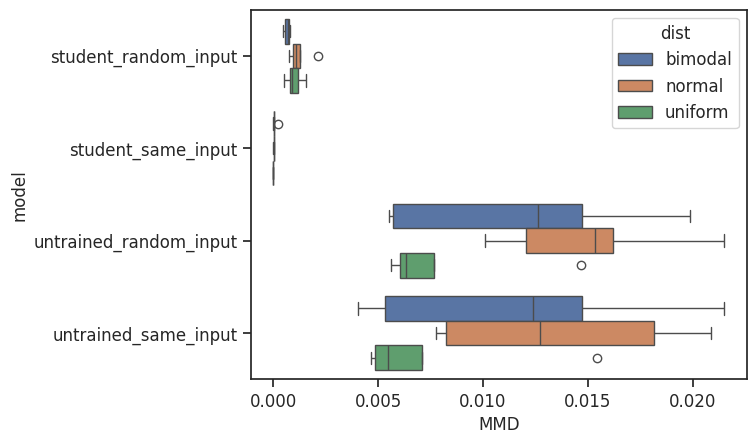

In [18]:
plt_data = data_MMD[data_MMD["model"]!="teacher_true"]
sns.boxplot(data=plt_data, y="model", x="MMD", hue="dist")
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Init_distributions_MMD_boxplot_all_inputs_three_dists.pdf", bbox_inches="tight")

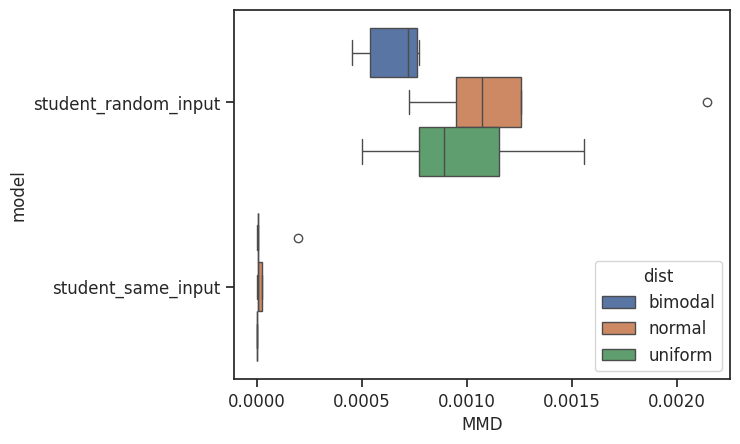

In [19]:
plt_data = data_MMD[data_MMD["model"].isin(['student_same_input', 'student_random_input'])]
sns.boxplot(data=plt_data, y="model", x="MMD", hue="dist")
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Init_distributions_MMD_boxplot_same_inputs_three_dists.pdf", bbox_inches="tight")

# EMD, all random and same inputs

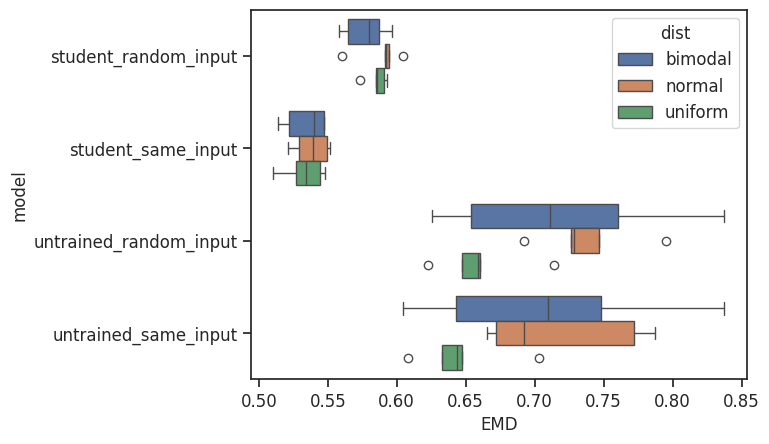

In [20]:
plt_data = data_EMD[data_EMD["model"]!="teacher_true"]
sns.boxplot(data=plt_data, y="model", x="EMD", hue="dist")
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Init_distributions_EMD_boxplot_all_inputs_three_dists.pdf", bbox_inches="tight")

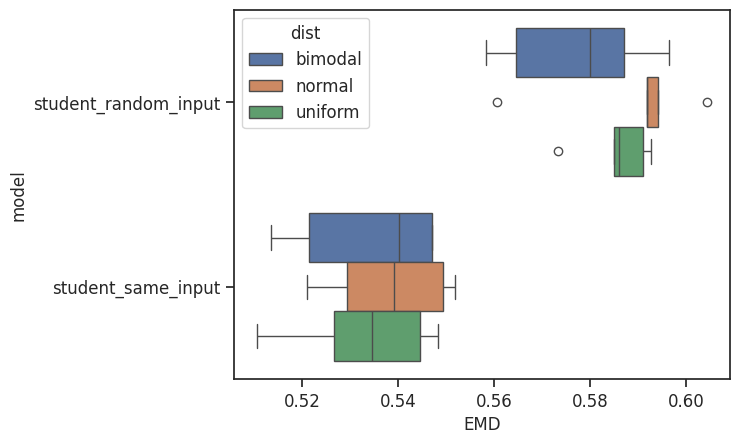

In [21]:
plt_data = data_EMD[data_EMD["model"].isin(['student_same_input', 'student_random_input'])]
sns.boxplot(data=plt_data, y="model", x="EMD", hue="dist")
plt.savefig("/dccstor/ipc1/CAR/BFN/Figures/Init_distributions_EMD_boxplot_same_inputs_three_dists.pdf", bbox_inches="tight")